In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression as lr

In [38]:
df = pd.read_csv("/content/drive/MyDrive/Causal_project/data/US_births(2018).csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
data = df.copy()
data.head()

,ATTEND,BFACIL,BMI,CIG_0,DBWT,DLMP_MM,DLMP_YY,DMAR,DOB_MM,DOB_TT,DOB_WK,DOB_YY,DWgt_R,FAGECOMB,FEDUC,FHISPX,FRACE15,FRACE31,FRACE6,ILLB_R,ILOP_R,ILP_R,IMP_SEX,IP_GON,LD_INDL,MAGER,MAGE_IMPFLG,MAR_IMP,MBSTATE_REC,MEDUC,MHISPX,MM_AICU,MRACE15,MRACE31,MRACEIMP,MRAVE6,MTRAN,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN
0,1,1,30.7,0,3657,4,2017,1,1,1227,2,2018,231,31,3,1,1,1,1,16,33,16,,N,N,30,,,1,6,0,N,1,1,,1,N,66,1,1,1,2,2,3,8,0,1,2,190,1,2,N,0,M,41
1,1,1,33.3,2,3242,99,9999,2,1,1704,2,2018,185,35,4,0,3,3,3,180,888,180,,N,N,35,,,1,9,0,N,3,3,,3,N,63,1,1,0,1,1,3,9,0,2,0,188,4,2,Y,2,F,0
2,1,1,30.0,0,3470,4,2017,1,1,336,2,2018,273,31,4,0,1,1,1,999,888,999,,N,N,28,,,1,6,0,N,1,1,,1,N,71,1,1,0,5,4,5,17,0,1,0,215,1,1,N,0,M,58
3,3,1,23.7,0,3140,5,2017,2,1,938,2,2018,138,26,2,0,3,3,3,43,888,43,,N,N,23,,,1,2,0,N,3,3,,3,N,64,1,1,1,1,1,5,6,0,2,0,138,1,2,N,0,F,0
4,1,1,35.5,0,2125,99,9999,1,1,830,3,2018,219,35,3,0,2,2,2,999,999,999,,N,N,37,,,1,4,0,N,1,1,,1,N,66,1,1,1,1,1,5,15,0,1,4,220,3,1,N,0,M,0


In [40]:
data.drop(data.columns.difference(
        ['BMI','DBWT','DMAR','DWgt_R','FEDUC','LD_INDL','MAGER'
        ,'MEDUC','NO_RISKS','PAY_REC','PRECARE','PREVIS'
        ,'PWgt_R','WTGAIN','M_Ht_In','RDMETH_REC','RF_CESAR', 'PRIORLIVE']), 1, inplace=True)

In [41]:
#  Dropping rows where missing values
data.drop(data[data['DBWT'].eq(9999)].index, inplace=True)    
data.drop(data[data['BMI'].eq(99.9)].index, inplace=True)
data.drop(data[data['WTGAIN'].eq(99)].index, inplace=True)
data.drop(data[data['PWgt_R'].eq(999)].index, inplace=True)
data.drop(data[data['NO_RISKS'].eq(9)].index, inplace=True)
data.drop(data[data['RDMETH_REC'].eq(9)].index, inplace=True)
data.drop(data[data['PAY_REC'].eq(9)].index, inplace=True)
data.drop(data[data['MAGER'].le(15)].index, inplace=True)
data.drop(data[data['MEDUC'].eq(9)].index, inplace=True)

In [42]:
data.rename(columns={"DBWT":"Birth Weight(g)", 'DMAR':'Marital Status','DWgt_R':'Mom Delivery Weight','RF_CESAR':'prev Cesarean',
'FEDUC':'dad educ','LD_INDL':'Induction of Labor','MAGER':'mom age','MEDUC':'mom edcu','M_Ht_In':'mom height'
,'PWgt_R':'Pre-pregnancy Weight','RDMETH_REC':'Delivery Method', 'PRIORLIVE':'Prior Births Living'},inplace=True)
data.head()

,BMI,Birth Weight(g),Marital Status,Mom Delivery Weight,dad educ,Induction of Labor,mom age,mom edcu,mom height,NO_RISKS,PAY_REC,PRECARE,PREVIS,Prior Births Living,Pre-pregnancy Weight,Delivery Method,prev Cesarean,WTGAIN
0,30.7,3657,1,231,3,N,30,6,66,1,2,3,8,1,190,1,N,41
2,30.0,3470,1,273,4,N,28,6,71,0,4,5,17,1,215,1,N,58
3,23.7,3140,2,138,2,N,23,2,64,1,1,5,6,2,138,1,N,0
4,35.5,2125,1,219,3,N,37,4,66,1,1,5,15,1,220,3,N,0
5,31.3,4082,1,247,6,N,26,6,67,1,2,2,13,1,200,1,N,47


* Marital Status: 1- merried, 2-unmerried
* education:
  1. 8th grade or less
  2. 9th through 12th grade with no diploma
  3. High school graduate or GED completed
  4. Some college credit, but not a degree.
  5. Associate degree (AA,AS)
  6. Bachelor’s degree (BA, AB, BS)
  7. Master’s degree (MA, MS, MEng, MEd, MSW, MBA)
  8. Doctorate (PhD, EdD) or Professional Degree (MD, DDS,
DVM, LLB, JD)
  9. Unknown
* PAY: 
  1. Medicade
  2. Private ins
  3. Self
  4. other
* Delivery Method:
  1. Vaginal (excludes vaginal after previous C-section)
  2. Vaginal after previous c-section 
  3. Primary C-section 
  4. Repeat C-section 
  5. Vaginal (unknown if previous c-section) 
  6. C-section (unknown if previous c-section) 

# **Mom education and Delivery Method**

---



In [43]:
## Add delivery column: 1= Vag, 0= Ceaserian

conditions = [data['Delivery Method'] == 1, data['Delivery Method'] == 2, data['Delivery Method'] == 3, data['Delivery Method'] == 4]
values = [1,1,0,0]
data['Delivery'] = np.select(conditions, values)
data['Delivery'].astype(np.int64)

0          1
2          1
3          1
4          0
5          1
          ..
3801528    0
3801529    0
3801530    1
3801531    1
3801533    1
Name: Delivery, Length: 3606465, dtype: int64

In [44]:
## Add T(education) column: 1= <=8th grade , 2= 9th-12th, 3= Full GED/Collage credit , 6= AA/BA, 5= MA+ 
conditions = [
              (data['mom edcu']==1),
              (data['mom edcu']==2),
              ((data['mom edcu']==3) | (data['mom edcu']==4)),
              ((data['mom edcu']==5) | (data['mom edcu']==6)),
              ((data['mom edcu']==7) | (data['mom edcu']==8))]
values = [1,2,3,4,5]
data['T'] = np.select(conditions, values)

## Change Y/N columns to 1/0
conditions2 = [data['Induction of Labor'] == 'N', data['Induction of Labor'] == 'Y']
values = [0,1]
data['Induction of Labor'] = np.select(conditions2, values)
conditions3 = [data['prev Cesarean'] == 'N', data['prev Cesarean'] == 'Y']
data['prev Cesarean'] = np.select(conditions3, values)

# Distribution plot

In [ ]:
data_res=data.sample(200000)

In [ ]:
data_res = data.sample(200000)
data_res.drop(data_res[data_res['NO_RISKS'].eq(0)].index, inplace=True)

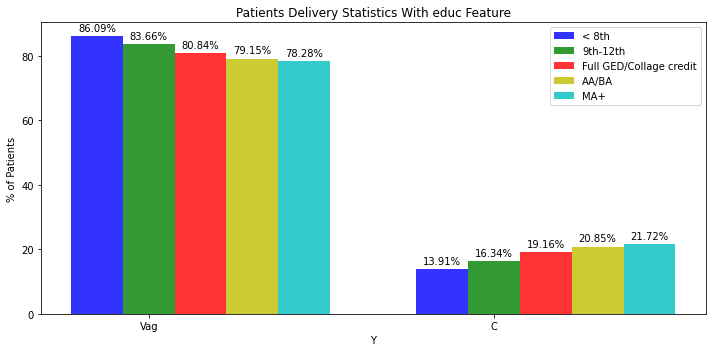

In [ ]:
t1 = (data_res[(data_res['Delivery'] == 1) & ((data_res['T']== 1))].shape[0],
           data_res[(data_res['Delivery'] == 2) & ((data_res['T']== 1))].shape[0])
t2 = (data_res[(data_res['Delivery'] == 1) & ((data_res['T']== 2))].shape[0],
           data_res[(data_res['Delivery'] == 2) & ((data_res['T']== 2))].shape[0])
t3 = (data_res[(data_res['Delivery'] == 1) & ((data_res['T']== 3))].shape[0],
           data_res[(data_res['Delivery'] == 2) & ((data_res['T']== 3))].shape[0])
t4 = (data_res[(data_res['Delivery'] == 1) & ((data_res['T']== 4))].shape[0],
           data_res[(data_res['Delivery'] == 2) & ((data_res['T']== 4))].shape[0])
t5 = (data_res[(data_res['Delivery'] == 1) & ((data_res['T']== 5))].shape[0],
           data_res[(data_res['Delivery'] == 2) & ((data_res['T']== 5))].shape[0])

# create plot
fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(2)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, t1/np.sum(data_res['T'] == 1)*100, bar_width,
                 alpha=opacity,
                 color='b',
                 label='< 8th')
 
rects2 = plt.bar(index + bar_width, t2/np.sum(data_res['T'] == 2)*100, bar_width,
                 alpha=opacity, tick_label = t2/np.sum(data_res['T'] == 2)*100,
                 color='g',
                 label='9th-12th')

rects3 = plt.bar(index + 2*bar_width, t3/np.sum(data_res['T'] == 3)*100, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Full GED/Collage credit')

rects4 = plt.bar(index + 3*bar_width, t4/np.sum(data_res['T'] == 4)*100, bar_width,
                 alpha=opacity,
                 color='y',
                 label='AA/BA')

rects5 = plt.bar(index + 4*bar_width, t5/np.sum(data_res['T'] == 5)*100, bar_width,
                 alpha=opacity,
                 color='c',
                 label='MA+')
 
plt.xlabel('Y')
plt.ylabel('% of Patients')
plt.title('Patients Delivery Statistics With educ Feature')
plt.xticks(index + bar_width, ('Vag', 'C'))
plt.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.tight_layout()
plt.show()

# **Propensity Score**

In [45]:
def model(data, t1, t2):
  data.drop(data[data['T'].ne(t1)].index & data[data['T'].ne(t2)].index,inplace=True)
  data.drop(['Marital Status','Delivery Method', 'mom edcu'], axis=1, inplace=True)
  
  conditions = [data['T'] == t1, data['T'] == t2]
  values = [0,1]
  data['T'] = np.select(conditions, values)
  
  Y = data['T'].copy()
  X = data.drop(['T', 'Delivery', 'PRECARE', 'PREVIS', 'PAY_REC','Induction of Labor',
                 'Birth Weight(g)','WTGAIN','Induction of Labor','Mom Delivery Weight'], axis=1).copy()

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

  lr_model = lr(solver='lbfgs', C=0.0025, multi_class='multinomial', max_iter=5000)

  lr_model.fit(X, Y)

  data['propensity'] = lr_model.predict_proba(X)[:,1]
  return data

In [ ]:
def trim_common_support(data, label, t1, t2):
  group_min_max = (data.groupby(label).propensity.agg(min_prop=np.min, max_prop= np.max))
  min_common_support = np.max(group_min_max.min_prop)
  max_common_support = np.min(group_min_max.max_prop)
  common_support = (data.propensity >= min_common_support) & (data.propensity <= max_common_support)
  control = (data[label] == t1)
  treated = (data[label] == t2)
  return data[common_support]

In [46]:
def IPW(ds):
  v1 = (ds['T']*ds['Delivery']) / (ds['propensity'])
  v1 = np.ma.masked_invalid(v1).sum()/len(ds)
  v2 = ((1-ds['T'])*ds['Delivery']) / (1-ds['propensity'])
  v2 = np.ma.masked_invalid(v1).sum()/len(ds)
  ATE = v1 - v2

  print('IPW ATE:', ATE)

In [47]:
def S_lerner(data):
  Y = data['Delivery']
  X = data.drop(['Delivery','propensity'], axis=1)

  model = lr(solver='lbfgs', C=0.0025, max_iter=5000)

  # model = rfr(n_estimators=Ntrees, max_features=0.8)

  model.fit(X,Y)

  Y_hat = model.predict(X)
  X_T1 = X.copy()
  X_T1['T'] = 1
  X_T0 = X_T1.copy()
  X_T0['T'] = 0

  print('S-Learner ATE:', (model.predict(X_T1) - model.predict(X_T0)).mean())

In [48]:
def T_lerner(data):
  X = data.drop(['Delivery', 'T', 'propensity'], axis=1)

  Y_0 = data[data['T'] == 0]['Delivery']
  X_0 = data[data['T'] == 0].drop(['Delivery', 'T', 'propensity'], axis=1)

  Y_1 = data[data['T'] == 1]['Delivery']
  X_1 = data[data['T'] == 1].drop(['Delivery', 'T', 'propensity'], axis=1)

  model_0 = lr(solver='lbfgs', C=0.0025, max_iter=5000)
  model_1 = lr(solver='lbfgs', C=0.0025, max_iter=5000)

  # model_0 = rfr(n_estimators=Ntrees, max_features=0.8)
  # model_1 = rfr(n_estimators=Ntrees, max_features=0.8)

  model_0.fit(X_0,Y_0)
  model_1.fit(X_1,Y_1)

  Y_01_hat = model_0.predict(X)
  Y_11_hat = model_1.predict(X)

  print('T-Learner ATE', (Y_11_hat - Y_01_hat).mean())

IPW ATE: 0.7036098989876487
S-Learner ATE: -0.005887129516849371
T-Learner ATE -0.07145757206658547


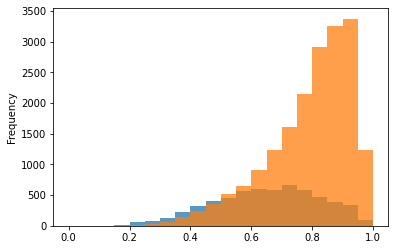

In [49]:
prop_data = data.sample(200000)
res = model(prop_data, 1, 2)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 0.6827133494568567
S-Learner ATE: -0.00448471121177803
T-Learner ATE -0.006532276330690826


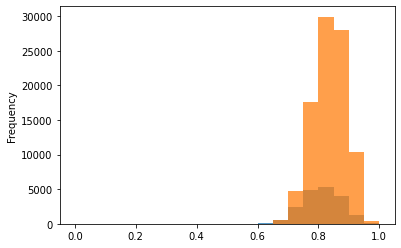

In [50]:
prop_data = data.sample(200000)
res = model(prop_data, 2, 3)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 0.6791307239659193
S-Learner ATE: -0.008706302628221484
T-Learner ATE -0.038836437866802756


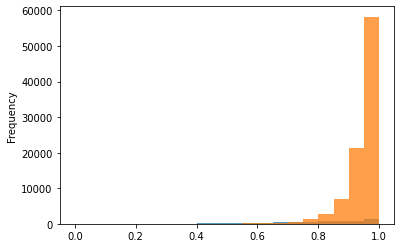

In [51]:
prop_data = data.sample(200000)
res = model(prop_data, 1, 3)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 6.2568166180971736e+16
S-Learner ATE: -0.0027755080865854765
T-Learner ATE -0.010492458140409581


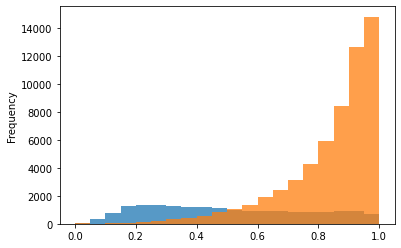

In [52]:
prop_data = data.sample(200000)
res = model(prop_data, 2, 4)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 27.809612049842105
S-Learner ATE: -0.001341156747694887
T-Learner ATE -0.014142018919889834


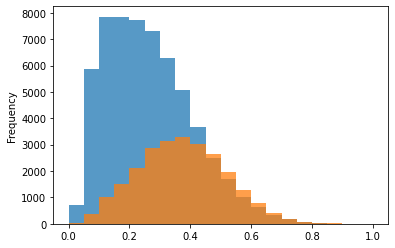

In [53]:
prop_data = data.sample(200000)
res = model(prop_data, 4, 5)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

In [54]:
def model2(data, t1, t2):
  data.drop(data[data['T'].ne(t1)].index & data[data['T'].ne(t2)].index,inplace=True)
  data.drop(['Marital Status','Delivery Method', 'mom edcu'], axis=1, inplace=True)
  
  conditions = [data['T'] == t1, data['T'] == t2]
  values = [0,1]
  data['T'] = np.select(conditions, values)
  
  Y = data['T'].copy()
  X = data.drop(['T', 'Delivery', 'PRECARE', 'PREVIS', 'PAY_REC','Induction of Labor',
                 'Birth Weight(g)','WTGAIN','Induction of Labor','Mom Delivery Weight', 'mom age'], axis=1).copy()

  # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

  lr_model = lr(solver='lbfgs', C=0.0025, multi_class='multinomial', max_iter=5000)

  lr_model.fit(X, Y)

  data['propensity'] = lr_model.predict_proba(X)[:,1]
  return data

IPW ATE: 10.826902968944212
S-Learner ATE: -0.004931285367825384
T-Learner ATE -0.07085691188358934


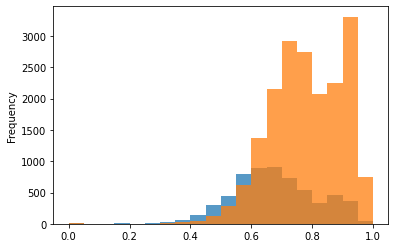

In [55]:
prop_data = data.sample(200000)
res = model2(prop_data, 1, 2)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 0.6837544966722685
S-Learner ATE: -0.0038647430443676124
T-Learner ATE -0.0004978006263236971


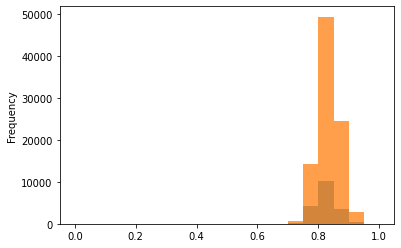

In [56]:
prop_data = data.sample(200000)
res = model2(prop_data, 2, 3)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 0.6814998654395786
S-Learner ATE: -0.007753049498663444
T-Learner ATE -0.04917092555228956


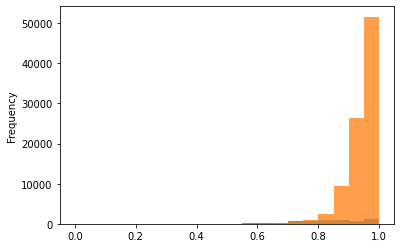

In [57]:
prop_data = data.sample(200000)
res = model2(prop_data, 1, 3)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 115.72134926541102
S-Learner ATE: -0.004436488169364882
T-Learner ATE -0.008003839767538398


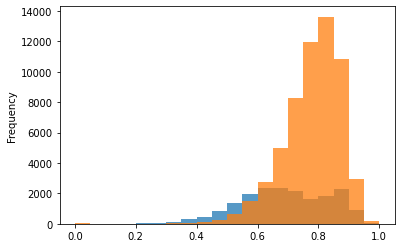

In [58]:
prop_data = data.sample(200000)
res = model2(prop_data, 2, 4)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)

IPW ATE: 0.653199737025421
S-Learner ATE: 0.005986228076489359
T-Learner ATE -0.0014875596823340292


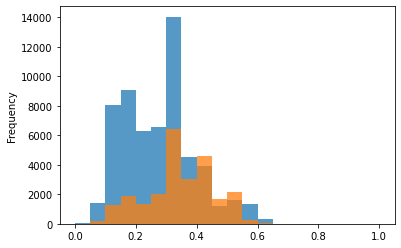

In [59]:
prop_data = data.sample(200000)
res = model2(prop_data, 4, 5)
res.groupby("T")['propensity'].plot(kind="hist", sharex=True, range=(0,1),bins=20, alpha=0.75)
IPW(res)
S_lerner(res)
T_lerner(res)